# Digital Image Processing - MIDTERM
## MUHAMMED ENES BAYSAN - 234312038

# Gerekli Kütüphanelerin Yüklenmesi

In [1]:
!pip install pandas
!pip install numpy
!pip install torch
!pip install torchvision
!pip install scikit-learn
!pip install matplotlib
!pip install keras
!pip install tensorflow
!pip install scikeras

In [2]:
!pip freeze > requirements.txt

In [54]:
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import GTSRB
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Layer
from scikeras.wrappers import KerasClassifier
import tensorflow.keras.backend as K
import tensorflow as tf

# Veri Seti Yükleme ve Ön İşleme

In [4]:
# **GTSRB tensör formatında bir veri setidir ve eksik değer içermemesi beklenir.**
# **GTSRB veri seti zaten eğitim ve test olarak ayrı verilmektedir.**

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((32, 32)),    # Görselleri 32x32 boyutuna getir
    transforms.ToTensor()          # Tensör formatına dönüştür
])

# Eğitim ve test veri setleri
train_dataset = GTSRB(root='./data', split='train', transform=transform, download=True)
test_dataset = GTSRB(root='./data', split='test', transform=transform, download=True)

# DataLoader ile veri setlerini yükle
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Eğitim verilerini NumPy dizilerine dönüştür
train_data = next(iter(train_loader))
X_train = train_data[0].numpy()  # Görseller
y_train = train_data[1].numpy()  # Etiketler

# Test verilerini NumPy dizilerine dönüştür
test_data = next(iter(test_loader))
X_test = test_data[0].numpy()  # Görseller
y_test = test_data[1].numpy()  # Etiketler

# Şekli düzleştirme (Flatten) - MLP ile uyumlu hale getirme
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Özellik ölçekleme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Eğitimi ve Hiperparametre Denemeleri

## MLP

In [5]:
# MLP Modeli oluşturma
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', learning_rate='adaptive', max_iter=500)
mlp.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', max_iter=500)

In [6]:
# Tahmin yapma
y_pred_mlp = mlp.predict(X_test)

In [7]:
# Performans değerlendirme
print("MLP Classifier Sonuçları (not optimized):")
print(classification_report(y_test, y_pred_mlp))

MLP Classifier Sonuçları (not optimized):
              precision    recall  f1-score   support

           0       0.78      0.23      0.36        60
           1       0.74      0.78      0.76       720
           2       0.77      0.87      0.82       750
           3       0.78      0.67      0.72       450
           4       0.77      0.72      0.74       660
           5       0.59      0.86      0.70       630
           6       0.87      0.74      0.80       150
           7       0.75      0.75      0.75       450
           8       0.81      0.75      0.78       450
           9       0.89      0.79      0.84       480
          10       0.85      0.96      0.90       660
          11       0.71      0.83      0.77       420
          12       0.97      0.90      0.93       690
          13       0.95      0.98      0.97       720
          14       0.97      0.84      0.90       270
          15       0.86      0.81      0.84       210
          16       0.99      0.90      

## RBF

Keras, varsayılan olarak "relu", "sigmoid", "tanh" gibi standart aktivasyon fonksiyonlarını destekler, ancak "rbf" (Radial Basis Function) yerleşik bir seçenek değildir.

RBF'yi kullanmak için özel bir aktivasyon fonksiyonu tanımlamamız gerekir.

In [74]:
# Özel RBF aktivasyon katmanı
class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma
    
    def build(self, input_shape):
        self.centers = self.add_weight(
            name="centers", shape=(self.units, input_shape[-1]), initializer="uniform", trainable=True
        )
        super(RBFLayer, self).build(input_shape)
    
    def call(self, inputs):
        # L2 normunu hesapla ve Gaussian kernel uygula
        diff = K.expand_dims(inputs, axis=1) - self.centers
        l2 = K.sum(K.square(diff), axis=-1)
        return K.exp(-self.gamma * l2)

In [75]:
# Sınıf ağırlıklarını hesapla
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 4.130232558139535, 1: 0.4130232558139535, 2: 0.4130232558139535, 3: 0.6453488372093024, 4: 0.4693446088794926, 5: 0.49169435215946844, 6: 2.0651162790697675, 7: 0.6453488372093024, 8: 0.6453488372093024, 9: 0.6257928118393234, 10: 0.45891472868217054, 11: 0.6883720930232559, 12: 0.4393864423552697, 13: 0.43023255813953487, 14: 1.1472868217054264, 15: 1.4750830564784052, 16: 2.0651162790697675, 17: 0.826046511627907, 18: 0.7648578811369509, 19: 4.130232558139535, 20: 2.5813953488372094, 21: 2.5813953488372094, 22: 2.294573643410853, 23: 1.7209302325581395, 24: 3.441860465116279, 25: 0.6073871409028728, 26: 1.4750830564784052, 27: 3.441860465116279, 28: 1.7209302325581395, 29: 3.441860465116279, 30: 2.0651162790697675, 31: 1.1472868217054264, 32: 3.441860465116279, 33: 1.2906976744186047, 34: 2.0651162790697675, 35: 0.7648578811369509, 36: 2.294573643410853, 37: 4.130232558139535, 38: 0.448938321536906, 39: 2.9501661129568104, 40: 2.5813953488372094, 41: 3.441860465116

In [76]:
# RBF için model
rbf_model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),  # Giriş boyutunu tanımla
    RBFLayer(50, gamma=0.001),  # RBF katmanı
    Dense(1, activation='sigmoid')  # Binary sınıflandırma için sigmoid çıkış
])

In [77]:
# Model derleme
rbf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
# Model eğitimi
rbf_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0581 - loss: -60.0854 - val_accuracy: 0.0570 - val_loss: -178.4615
Epoch 2/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0558 - loss: -324.0904 - val_accuracy: 0.0570 - val_loss: -360.3947
Epoch 3/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0556 - loss: -566.2919 - val_accuracy: 0.0570 - val_loss: -526.8763
Epoch 4/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0583 - loss: -793.7133 - val_accuracy: 0.0570 - val_loss: -690.6753
Epoch 5/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0585 - loss: -1043.3724 - val_accuracy: 0.0570 - val_loss: -854.8951
Epoch 6/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0550 - loss: -1294.7760 - val_accuracy: 0.0570 - val_loss: -1016.2245
Epoch 7/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0559 - loss: -1451.0415 - val_accuracy: 0.0570 - val_loss: -1182.5143
Epoch 8/50
833/833 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accu

In [79]:
# Tahmin yapma
y_pred_rbf = (rbf_model.predict(X_test) > 0.5).astype("int32")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [80]:
print("Unique predictions:", np.unique(y_pred_rbf))

Unique predictions: [1]


In [81]:
# Performans değerlendirme
print("RBF Classifier Sonuçları:")
print(classification_report(y_test, y_pred_rbf))

RBF Classifier Sonuçları:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.06      1.00      0.11       720
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       0.00      0.00      0.00       630
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       0.00      0.00      0.00       150
 

/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

# Performans Ölçümleri

## MLP

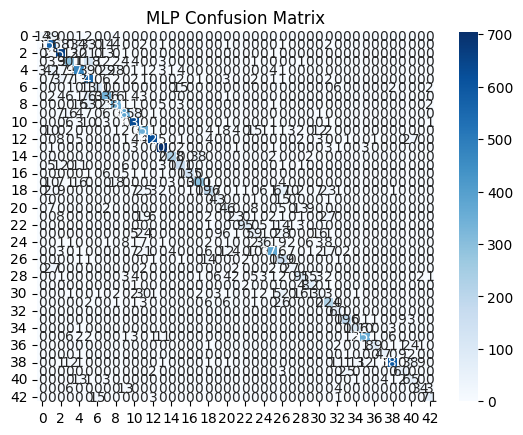

In [14]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title("MLP Confusion Matrix")
plt.show()

## RBF

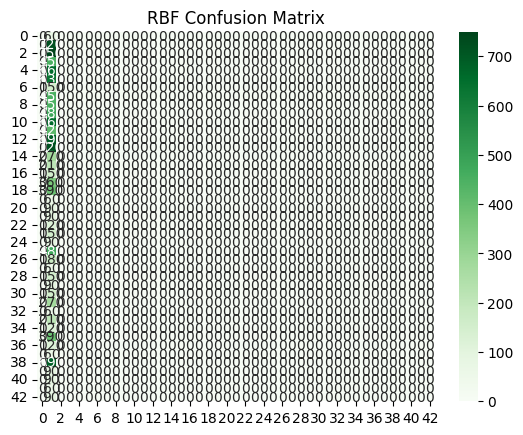

In [15]:
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Greens')
plt.title("RBF Confusion Matrix")
plt.show()

# Hiperparametre Optimizasyonları ve Sonuçları Karşılaştırma

## MLP

In [16]:
# MLP için hiperparametre arama
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive']
}

In [17]:
grid_search = GridSearchCV(MLPClassifier(max_iter=500), param_grid, cv=3, scoring='accuracy')

In [18]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500),
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                         'learning_rate': ['constant', 'adaptive']},
             scoring='accuracy')

In [19]:
print("En iyi MLP parametreleri:", grid_search.best_params_)

En iyi MLP parametreleri: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}


In [20]:
# En iyi MLP modelini elde etme
best_mlp_model = grid_search.best_estimator_

In [21]:
# Optimize edilmiş MLP modeliyle test setinde tahmin yapma
y_pred_mlp_optimized = best_mlp_model.predict(X_test)

In [22]:
# Performans metrikleri
print("Optimizasyon Sonrası MLP Model Performansı:")
print(classification_report(y_test, y_pred_mlp_optimized))

Optimizasyon Sonrası MLP Model Performansı:
              precision    recall  f1-score   support

           0       0.72      0.43      0.54        60
           1       0.77      0.82      0.80       720
           2       0.79      0.84      0.81       750
           3       0.73      0.83      0.78       450
           4       0.77      0.73      0.75       660
           5       0.61      0.82      0.70       630
           6       0.76      0.84      0.80       150
           7       0.85      0.62      0.71       450
           8       0.86      0.78      0.82       450
           9       0.87      0.80      0.83       480
          10       0.92      0.91      0.91       660
          11       0.87      0.87      0.87       420
          12       0.98      0.94      0.96       690
          13       0.95      0.94      0.94       720
          14       0.95      0.83      0.89       270
          15       0.73      0.73      0.73       210
          16       0.89      0.85    

## RBF

In [23]:
def create_rbf_model(neurons=50, gamma=0.5, optimizer='adam'):
    model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),  # Giriş boyutunu tanımla
        RBFLayer(neurons, gamma=gamma),  # RBF katmanı, 'neurons' parametresi ile
        Dense(1, activation='sigmoid')  # Binary sınıflandırma için sigmoid çıkış
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
rbf_classifier = KerasClassifier(build_fn=create_rbf_model, verbose=0, gamma=0.1, neurons=50)

In [25]:
# Hiperparametre tanımlama
param_grid = {
    'neurons': [20, 50],       # Farklı nöron sayıları
    'gamma': [0.1, 0.5],       # Farklı gamma değerleri
    'optimizer': ['adam', 'sgd'],   # Farklı optimizasyon algoritmaları
    #'epochs': [10, 50],            # Farklı epoch sayıları
    #'batch_size': [5, 10]          # Farklı batch boyutları
}

In [26]:
# GridSearchCV ile hiperparametre optimizasyonu
grid_search_rbf = GridSearchCV(estimator=rbf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

In [27]:
grid_search_rbf.estimator.get_params

<bound method BaseEstimator.get_params of KerasClassifier(
	model=None
	build_fn=<function create_rbf_model at 0x3305b40e0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	gamma=0.1
	neurons=50
	class_weight=None
)>

In [28]:
grid_search_rbf.fit(X_train, y_train)

/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, 

GridSearchCV(cv=3,
             estimator=KerasClassifier(build_fn=<function create_rbf_model at 0x3305b40e0>, gamma=0.1, neurons=50, verbose=0),
             n_jobs=-1,
             param_grid={'gamma': [0.1, 0.5], 'neurons': [20, 50],
                         'optimizer': ['adam', 'sgd']},
             scoring='accuracy')

In [29]:
# En iyi parametreler ve skor
print("En iyi RBF parametreleri:", grid_search_rbf.best_params_)
print("En iyi RBF doğruluk skoru:", grid_search_rbf.best_score_)

En iyi RBF parametreleri: {'gamma': 0.1, 'neurons': 20, 'optimizer': 'adam'}
En iyi RBF doğruluk skoru: 0.005630630630630631


In [30]:
# En iyi model ile test setinde tahmin yapma
best_rbf_model = grid_search_rbf.best_estimator_
y_pred_rbf_optimized = best_rbf_model.predict(X_test)

In [31]:
# Performans metrikleri
print("Optimizasyon Sonrası RBF Model Performansı:")
print(classification_report(y_test, y_pred_rbf_optimized))

Optimizasyon Sonrası RBF Model Performansı:
              precision    recall  f1-score   support

           0       0.00      1.00      0.01        60
           1       0.00      0.00      0.00       720
           2       0.00      0.00      0.00       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       0.00      0.00      0.00       630
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       0.00      0.00    

/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

# Sonuçların görselleştirilmesi

In [37]:
results = pd.DataFrame({
    'Model': ['MLP', 'RBF'],
    'Accuracy': [accuracy_score(y_test, y_pred_mlp), accuracy_score(y_test, y_pred_rbf)],
    'Precision': [precision_score(y_test, y_pred_mlp, average='weighted'), precision_score(y_test, y_pred_rbf, average='weighted')],
    'Recall': [recall_score(y_test, y_pred_mlp, average='weighted'), recall_score(y_test, y_pred_rbf, average='weighted')],
    'F1-Score': [f1_score(y_test, y_pred_mlp, average='weighted'), f1_score(y_test, y_pred_rbf, average='weighted')]
})

/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
print(results)

  Model  Accuracy  Precision    Recall  F1-Score
0   MLP  0.793587   0.808685  0.793587  0.792712
1   RBF  0.057007   0.003250  0.057007  0.006149


In [45]:
results_optimized = pd.DataFrame({
    'Model': ['MLP', 'RBF'],
    'Accuracy': [accuracy_score(y_test, y_pred_mlp), accuracy_score(y_test, y_pred_rbf)],
    'Precision': [precision_score(y_test, y_pred_mlp, average='weighted'), precision_score(y_test, y_pred_rbf, average='weighted')],
    'Recall': [recall_score(y_test, y_pred_mlp, average='weighted'), recall_score(y_test, y_pred_rbf, average='weighted')],
    'F1-Score': [f1_score(y_test, y_pred_mlp, average='weighted'), f1_score(y_test, y_pred_rbf, average='weighted')]
})

/Users/mebaysan/Workspace/Experimental/AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Performans Karşılaştırması

In [43]:
# Performansları karşılaştırma
results = pd.DataFrame({
    'Model': ['MLP (Default)', 'MLP (Optimized)', 'RBF (Default)', 'RBF (Optimized)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_mlp), 
        accuracy_score(y_test, y_pred_mlp_optimized), 
        accuracy_score(y_test, y_pred_rbf), 
        accuracy_score(y_test, y_pred_rbf_optimized)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_mlp, average='weighted'), 
        f1_score(y_test, y_pred_mlp_optimized, average='weighted'), 
        f1_score(y_test, y_pred_rbf, average='weighted'), 
        f1_score(y_test, y_pred_rbf_optimized, average='weighted')
    ]
})

print(results)

             Model  Accuracy  F1-Score
0    MLP (Default)  0.793587  0.792712
1  MLP (Optimized)  0.808709  0.806694
2    RBF (Default)  0.057007  0.006149
3  RBF (Optimized)  0.004751  0.000045


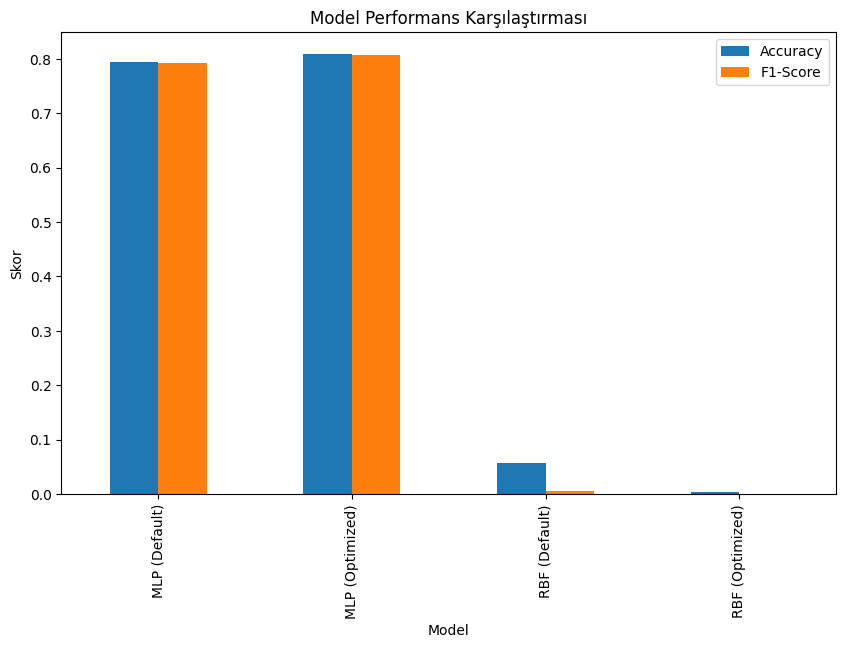

In [44]:
# Sonuçları görselleştirme
results.plot(x='Model', kind='bar', figsize=(10, 6), title="Model Performans Karşılaştırması")
plt.ylabel("Skor")
plt.show()

# Yorumlar

- Veri seti için en iyi model Optimize Edilmiş MLP modelidir.
- RBF modelleri, hem varsayılan hem de optimize edilmiş halleriyle başarısız olmuş ve veri setine uygun bir çözüm sunamamıştır.

### MLP Modelleri

- MLP modelleri veri seti üzerinde tutarlı bir şekilde iyi performans gösteriyor.
- Optimize edilmiş MLP modeli, varsayılan modelden daha iyi sonuçlar vererek hiperparametre optimizasyonunun önemini ortaya koyuyor.
- Bu sonuçlar, MLP'nin veri setinin doğrusal olmayan yapısını başarılı bir şekilde modelleyebildiğini gösteriyor.

### RBF Modelleri

- Modeli oluştururken doğru parametreleri seçememiş olabilirim.
- Hem varsayılan hem de optimize edilmiş RBF modelleri başarısız sonuçlar veriyor.
- Bu, RBF katmanlarının veri setindeki yapıyı anlamakta zorlandığını veya hiperparametrelerin yanlış seçildiğini gösteriyor.

### MLP vs RBF

- MLP modelleri RBF modellerine kıyasla açık ara daha başarılıdır.
- RBF modellerinin başarısızlığı, özellikle büyük veri setlerinde veya karmaşık yapıda verilerde RBF'nin zorluklar yaşayabileceğini gösteriyor.